In [465]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import warnings
from tqdm import tqdm
import seaborn as sns
random_state =537

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import xgboost as xgb
from lightgbm import LGBMRegressor as lgbm
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
#lstm,lgtbm,nerualprophet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import datetime

In [466]:
class config:
    target = "Dağıtılan Enerji (MWh)"
    draw=False
    cross_val = True 
    sub = True 
   
    temp = True
    holiday = True
    drop_med = True #if holiday false is work!!
    time_feature = True
    lag = True #automatically disabled if model is RF!!
    outilar = False
    rolling = False
    

    ensamble_list = ["RF","XGB","LGBM","Prophet"]#Ensembleception #"RF","XGM","LGBM","Prophet" 
    #the value corresponding to the model must be defined in the ensemble_weight
    ensamble_weight = [0.35,0.15,0.15,0.35]#["RF","XGB","LGBM","Prophet"]
    
    
    seosanilty = []
    scores = []
    submission_20 = []
    feature = []
    lag_feature = []
    rol_feature = []
    metric = ""
    began  = datetime.datetime.now()
    end = ""
    mean = ""
    pandem = ['2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25',
    '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30',
    '2021-05-01', '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05',
    '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10',
    '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15',
    '2021-05-16', '2021-05-17', '2021-05-18', '2021-05-19', '2020-04-11',
    '2020-04-12', '2020-04-13', '2020-04-17', '2020-04-18', '2020-04-19',
    '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
    '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-23', '2020-05-24',
    '2020-05-25', '2020-05-26']
    
    
   
    def debug_log(wandb=""):
        print("-"*50)
        print("Began Time:",config.began)
        print("-"*40)
        print("Model_List:",config.ensamble_list,"Weights:",config.ensamble_weight)
        print("-"*40)
        print("Features:\n",config.feature,config.lag_feature,config.rol_feature,config.seosanilty,sep="")
        print("Target:\n",config.target,sep="")
        print("-"*40)
        print("Temp:",config.temp,"\n Outilar:",config.outilar,"\n Rolling:",config.rolling)
        print("Holiday:",config.holiday,",Drop_med:",config.drop_med)
        print("Time_feature:",config.time_feature)
        print("Lag:",config.lag)
        print("-"*40)
        print("Metric:",config.metric)
        print(f'Score across folds {np.mean(config.scores):0.4f}')
        print(f'Fold scores:{config.scores}')
        print(f'Predictes values mean:{config.mean}')
        print("-"*40)
        print("Submission.head(20):\n",config.submission_20,sep="")
        print("-"*40)
        config.end = datetime.datetime.now()
        print("End Time:",config.end)
        print("-"*50)        

In [467]:
train_raw = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/train.csv")
sample_sub = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv")
med= pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/med.csv")
submission = sample_sub.copy()
train_raw["flag"] = "train"
sample_sub["flag"] = "sub"
temp = pd.read_csv("/kaggle/input/2018-2023-izmirtemp/temp2.csv")

In [468]:
# train_raw = train_raw.loc[(train_raw[config.target]>1000),:].copy()
# train_raw.loc[(train_raw[config.target]<1000),config.target] = np.nan
# train_raw["outilar"] = 0
# train_raw.loc[(train_raw[config.target].isna()),"outilar"] = 1

train_raw[config.target] = np.log1p(train_raw[config.target])


In [469]:
df = pd.concat([train_raw,sample_sub],axis=0).copy()
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')


# adding to train set
df['is_spring'] = df['Tarih'].apply(is_spring)
df['is_summer'] = df['Tarih'].apply(is_summer)
df['is_autumn'] = df['Tarih'].apply(is_autumn)
df['is_winter'] = df['Tarih'].apply(is_winter)
df['is_weekend'] = df['Tarih'].apply(is_weekend)
df['is_weekday'] = ~df['Tarih'].apply(is_weekend)

config.seosanilty = ["is_spring","is_summer","is_autumn","is_winter","is_weekend","is_weekday"]


In [470]:

df["Tarih2"] = df.Tarih.apply(lambda x:x[:10])
df.Tarih = pd.to_datetime(df.Tarih)
df.set_index("Tarih",inplace=True,drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40896 entries, 2018-01-01 00:00:00 to 2022-08-31 23:00:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40896 non-null  float64
 1   flag                    40896 non-null  object 
 2   is_spring               40896 non-null  bool   
 3   is_summer               40896 non-null  bool   
 4   is_autumn               40896 non-null  bool   
 5   is_winter               40896 non-null  bool   
 6   is_weekend              40896 non-null  bool   
 7   is_weekday              40896 non-null  bool   
 8   Tarih2                  40896 non-null  object 
dtypes: bool(6), float64(1), object(2)
memory usage: 1.5+ MB


# EDA

In [471]:
if(~config.draw): #autocorelation 
    values = df[df.flag =="train"].iloc[:,:1]
    dataframe = pd.concat([values.shift(50), values.shift(60),
                           values.shift(720), values], axis=1)
    # naming the columns
    dataframe.columns = ['t+30', 't+60', 't+365', 't']

    # using corr() function to compute the correlation
    result = dataframe.corr()

    print(result)

           t+30      t+60     t+365         t
t+30   1.000000 -0.002010  0.667663  0.752282
t+60  -0.002010  1.000000 -0.201733 -0.103000
t+365  0.667663 -0.201733  1.000000  0.697290
t      0.752282 -0.103000  0.697290  1.000000


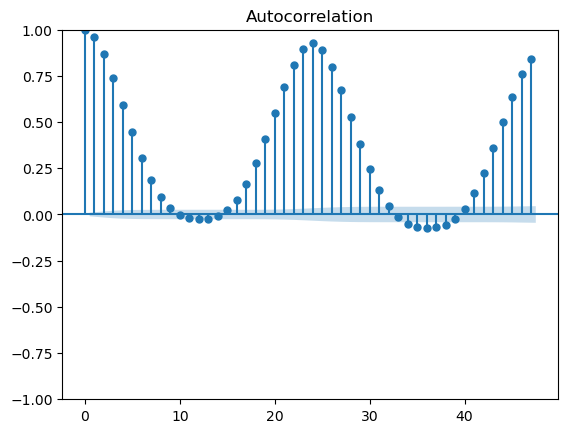

In [472]:
if(~config.draw):#autocorelation 
    from statsmodels.graphics.tsaplots import plot_acf
    data = df[df.flag =="train"].loc[:,config.target]
    plot_acf(data)

In [473]:
if(config.draw):
    df.plot(style='.',figsize=(20, 5),title='')
    plt.show()

# Feature Eng.

In [474]:
if(config.temp):
    temp2  =temp.iloc[:,:2].rename(columns={"Yerel zaman İzmir kentine ait":"Tarih","T":"Temp"}).copy()
    temp2.Tarih = pd.to_datetime(temp2.Tarih)    
    temp2.set_index("Tarih",inplace=True,drop=True)
    df = pd.concat([temp2,df],axis=1)
    df = df[df[config.target].notna()]
    df.fillna(method="ffill",inplace=True)
    df.Temp = df.Temp.shift(1)
    df.fillna(method="bfill",inplace=True)
    config.feature.append("Temp")


In [475]:
if(config.holiday):
    hol = pd.read_csv('/kaggle/input/turkish-calendar-1994-2024/Calendar.csv')
    hol = hol[['CALENDAR_DATE','RAMADAN_FLAG','PUBLIC_HOLIDAY_FLAG']].rename(columns={'CALENDAR_DATE':'ds'})
    hol['holiday'] = np.where((hol['RAMADAN_FLAG'] == 'Y') | (hol['PUBLIC_HOLIDAY_FLAG'] == 'Y'), 'TR-Holidays', 0)
    hol = hol[['ds','holiday']]
    hol = hol[hol['holiday'] == 'TR-Holidays']
    pan = pd.DataFrame(config.pandem,columns=["ds"])
    pan["holiday"] = "pandemi"
    hol = pd.concat([pan,hol])
    med["holiday"] = "powercut"
    med.rename(columns={"Tarih":"ds"},inplace=True)
    hol = pd.concat([med,hol])
    hol.rename(columns={"ds":"Tarih2"},inplace=True)
    df["holiday"] = df.Tarih2.map(dict(zip(hol.Tarih2,hol.holiday)))
    df.loc[df.holiday.isna(),"holiday"] = "normal"
    df.drop(["Tarih2"],axis=1,inplace=True)
    config.feature.append("holiday")
elif(config.drop_med):
    med["med"] = 1
    df["med"] = df.Tarih2.map(dict(zip(med.Tarih,med.med)))
    df.loc[df.med != 1,"med"] = 0
    df.drop(df[df.med == 1].index,axis=0,inplace=True)
    df.drop(["Tarih2","med"],axis=1,inplace=True)    

In [476]:
# outilar = train_raw.loc[(train_raw[config.target]<1000),:].Tarih.reset_index().drop(["index"],axis=1)
# outilar["holiday"] = "outilar"
# pd.concat([outilar,hol])
# outilaroutilar

In [477]:
if(config.time_feature):
    def create_features(df):
        """
        Create time series features based on time series index.
        """
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        #df['weekofyear'] = df.index.isocalendar().week
        return df

    df = create_features(df)
    config.feature.extend(["hour","dayofweek","quarter","month","year","dayofyear","dayofmonth"])

In [478]:
if(config.draw):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(data=df, x='hour', y='Dağıtılan Enerji (MWh)')
    ax.set_title('MW by Hour')
    plt.show()
    df.loc[df[config.target]<1000,config.target].plot(style='.',
          figsize=(15, 5),
          title='Outliers')
    plt.show()
    df[config.target].plot(kind='hist', bins=500)

In [479]:
df=pd.concat([df,pd.get_dummies(df["holiday"])],axis=1).drop(["holiday"],axis=1)
# yukarı taşındk

In [480]:
if(config.holiday):
    config.feature.remove("holiday")
    for i in["TR-Holidays","pandemi","powercut"]:
        df[i] = df[i].astype(int)
        config.feature.append(i)

# Lag feature


In [481]:
if(config.lag):
    def add_lags(df,feature_name=config.target):
        if(feature_name == config.target):
            target_map = df[feature_name].to_dict()
            df[f'lag_30-{feature_name}'] = (df.index - pd.Timedelta('30 days')).map(target_map)
            df[f'lag_60-{feature_name}'] = (df.index - pd.Timedelta('60 days')).map(target_map)
            df[f'lag_360-{feature_name}'] = (df.index - pd.Timedelta('360 days')).map(target_map)
            df[f'lag_720-{feature_name}'] = (df.index - pd.Timedelta('720 days')).map(target_map)
            config.lag_feature.extend([f'lag_30-{feature_name}',f'lag_60-{feature_name}',f'lag_360-{feature_name}',f'lag_720-{feature_name}']),
        if(feature_name == "Temp"):
            target_map = df[feature_name].to_dict()
            df[f'lag_1-{feature_name}'] = (df.index - pd.Timedelta('1 days')).map(target_map)
            df[f'lag_2-{feature_name}'] = (df.index - pd.Timedelta('2 days')).map(target_map)
            df[f'lag_3-{feature_name}'] = (df.index - pd.Timedelta('3 days')).map(target_map)
            df[f'lag_4-{feature_name}'] = (df.index - pd.Timedelta('4 days')).map(target_map)
            config.lag_feature.extend([f'lag_1-{feature_name}',f'lag_2-{feature_name}',f'lag_3-{feature_name}',f'lag_4-{feature_name}'])            
        return df
#     return df
    add_lags(df)
    if(config.temp):
        add_lags(df,feature_name="Temp")

In [482]:
if(config.rolling):#config.avarage)True):#:
    df['rolling_mean_30'] = df[config.target].transform(lambda x: x.rolling(120).mean())
    
#     df['rolling_median_30'] = df[config.target].transform(lambda x: x.rolling(60).median())
  
#     df['rolling_std_30'] = df[config.target].transform(lambda x: x.rolling(60).std())
    config.rol_feature.extend(["rolling_mean_30"])#,"rolling_median_30","rolling_std_30"])


# Train Test split


In [483]:
sub = df.loc[df["flag"]=="sub",:].drop(["flag"],axis=1)
df = df.loc[df["flag"]=="train",:].drop(["flag"],axis=1)

In [484]:
# train = df.loc[df.index < '07-01-2021']
# test = df.loc[df.index >= '07-01-2021']

# fig, ax = plt.subplots(figsize=(15, 5))
# train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
# test.plot(ax=ax, label='Test Set')
# ax.axvline('07-01-2021', color='black', ls='--')
# ax.legend(['Training Set', 'Test Set'])
# plt.show()

In [485]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24*180*1, gap=24)
df = df.sort_index()

In [486]:
if(config.draw):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train[config.target].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
        test[config.target].plot(ax=axs[fold],
                             label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()

# Train

In [487]:
config.ensamble_list

['RF', 'XGB', 'LGBM', 'Prophet']

In [488]:
def model_xgb(X_train,y_train,X_test,y_test=pd.DataFrame(),sub=pd.DataFrame()):
    
    
    
    if(y_test.empty):
        reg1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                   n_estimators=500,
                                   #early_stopping_rounds=50,
                                   objective='reg:linear',
                                   max_depth=3,
                                   learning_rate=0.01
                                  )
        reg1.fit(X_train, y_train,
                    #eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100
                   )
    else:
        reg1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                   n_estimators=500,
                                   early_stopping_rounds=50,
                                   objective='reg:linear',
                                   max_depth=3,
                                   learning_rate=0.01
                                  )
        reg1.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100
                   )
        
    y_pred1 = reg1.predict(X_test)
#             sub_pred1=reg1.predict(sub[config.feature+config.lag_feature])
#             sub_pred = sub_pred1

    if(config.sub):
        res = reg1.predict(sub)
    reg = reg1
    y_pred = y_pred1
    return reg1,y_pred1,reg,y_pred,res
    

In [489]:
def model_lgbm(X_train,y_train,X_test,y_test=pd.DataFrame(),sub=pd.DataFrame()):
    reg2 = lgbm()
    if(y_test.empty):
        reg2.fit(X_train, y_train,
                        #eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=100
                       )
    else:
        reg2.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=100
                       )
    y_pred2 = reg2.predict(X_test)
#             sub_pred2=reg2.predict(sub[config.feature+config.lag_feature])
#             sub_pred = sub_pred2

    if(config.sub):
        res = reg2.predict(sub)
        
    reg = reg2
    y_pred = y_pred2
    return reg2,y_pred2,reg,y_pred,res

In [490]:
def model_rf(X_train_RF,y_train,X_test_RF,sub=pd.DataFrame()):
    reg3 = RandomForestRegressor(n_estimators=100, random_state=random_state)
    reg3.fit(X_train_RF, y_train,
                    #eval_set=[(X_train, y_train), (X_test, y_test)],
                   # verbose=100
                   )
    y_pred3 = reg3.predict(X_test_RF)
# #             sub_pred3 = reg3.predict(sub[config.feature])
# #             sub_pred = sub_pred3

    if(config.sub):
            res = reg3.predict(sub)
    reg = reg3
    y_pred = y_pred3
    return reg3,y_pred3,reg,y_pred,res

In [491]:
def model_prophet(hol,X_train_prophet,X_test_prophet):
    hol.rename(columns={"Tarih2":"ds"},inplace=True)
    hol.ds = pd.to_datetime(hol.ds)
    reg4 = Prophet(holidays=hol)
    reg4.add_seasonality(name='yearly', period=365.25, fourier_order=10)
    reg4.add_seasonality(name='weekly_spring', 
                                    period=7,
                                    fourier_order=5, 
                                    condition_name='is_spring')
    reg4.add_seasonality(name='weekly_summer', 
                                    period=7,
                                    fourier_order=5, 
                                    condition_name='is_summer')
    reg4.add_seasonality(name='weekly_autumn', 
                                    period=7,
                                    fourier_order=5, 
                                    condition_name='is_autumn')
    reg4.add_seasonality(name='weekly_winter', 
                                    period=7,
                                    fourier_order=5, 
                                    condition_name='is_winter')
    reg4.add_seasonality(name='daily_spring',  
                                    period=1,
                                    fourier_order=5, 
                                    condition_name='is_spring')
    reg4.add_seasonality(name='daily_summer',  
                                    period=1,
                                    fourier_order=5, 
                                    condition_name='is_summer')
    reg4.add_seasonality(name='daily_autumn',  
                                    period=1,
                                    fourier_order=5, 
                                    condition_name='is_autumn')
    reg4.add_seasonality(name='daily_winter',  
                                    period=1,
                                    fourier_order=5, 
                                    condition_name='is_winter')
    reg4.add_seasonality(name='daily_weekend',  
                                    period=1,
                                    fourier_order=5, 
                                    condition_name='is_weekend')
    reg4.add_seasonality(name='daily_weekday',  
                                    period=1,
                                    fourier_order=5, 
                                    condition_name='is_weekday')
#     reg4.add_regressor("outilar")
    reg4.fit(X_train_prophet)
    y_pred4 = reg4.predict(X_test_prophet)
#             sub_pred4 =reg4.predict(sub[config.feature+config.seosanilty].reset_index().rename(columns={"Tarih":"ds"})).yhat
#             sub_pred = sub_pred4
    reg = reg4
    y_pred4_frcst = y_pred4.copy()
    y_pred4 = y_pred4.yhat
    y_pred = y_pred4
    return reg4,y_pred4,reg,y_pred,y_pred4_frcst

In [492]:
def cross_val_data_prep(df,train_idx="",val_idx=""):
    if(train_idx != ""):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        
    else:
        train = df.copy()
        test = df.copy()
        
    train2 = train.copy()
#     train2["Tarih2"] = train2.ds.apply(lambda x:x[:10])
#     train_raw = train_raw[~train_raw.Tarih2.isin(config.pandem)].drop(["Tarih2"],axis=1)
    if(config.outilar):
        train2=train2[~train2.index.isin(ai)]
#         print(train2.shape)
        train2=train2[~train2.index.isin(pai)]
#         print(train2.shape)
#     train2=train2[~train2.index.isin(pai)]
#     train2=train2[~train2.index.isin(poi)]
    
    FEATURES = config.feature
    TARGET = config.target

    X_train = train2[FEATURES+config.lag_feature+config.rol_feature]
    y_train = train2[TARGET]

    X_test = test[FEATURES+config.lag_feature+config.rol_feature]
    y_test = test[TARGET]

    X_train_RF = train2[FEATURES]
    X_test_RF = test[FEATURES]
    
    X_train_prophet = pd.concat([train[FEATURES+config.seosanilty],train[TARGET]],axis=1)
    X_test_prophet = test[FEATURES+config.seosanilty]
    X_train_prophet = X_train_prophet.reset_index().rename(columns={"Tarih":"ds",config.target:"y"})
    X_test_prophet = X_test_prophet.reset_index().rename(columns={"Tarih":"ds"})
    return X_train,y_train,X_test,y_test,X_train_RF,X_test_RF,X_train_prophet,X_test_prophet

In [493]:
sub_pred_main = []
y_pred4=0
if(config.cross_val):
    fold = 0
    preds = []
    scores = []
    for train_idx, val_idx in tss.split(df):

        X_train,y_train,X_test,y_test,X_train_RF,X_test_RF,X_train_prophet,X_test_prophet =  cross_val_data_prep(df,train_idx,val_idx)
        
        if("XGB" in config.ensamble_list):
            reg1,y_pred1,reg,y_pred,sub_pred1 = model_xgb(X_train,y_train,X_test,y_test,sub[config.feature+config.lag_feature+config.rol_feature])
        if("LGBM" in config.ensamble_list):
            reg2,y_pred2,reg,y_pred,sub_pred2 = model_lgbm(X_train,y_train,X_test,y_test,sub[config.feature+config.lag_feature+config.rol_feature])
        if("RF" in config.ensamble_list):
            reg3,y_pred3,reg,y_pred,sub_pred3 = model_rf(X_train_RF,y_train,X_test_RF,sub[config.feature])
        if("Prophet" in config.ensamble_list):
            reg4,y_pred4,reg,y_pred,y_pred4_frcst = model_prophet(hol,X_train_prophet,X_test_prophet)
        if(len(config.ensamble_list) != 0):
            y_pred = y_pred3*0.50+y_pred2*0.25+y_pred1*0.25#+y_pred4*config.ensamble_weight[3]
            sub_pred_main.append(sub_pred3*config.ensamble_weight[0]+sub_pred2*config.ensamble_weight[2]+sub_pred1*config.ensamble_weight[1])

        preds.append(y_pred)
        score = np.sqrt(mean_absolute_percentage_error(y_test, y_pred))
        scores.append(score)


[20:22:37] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.90731	validation_1-rmse:6.96623
[100]	validation_0-rmse:2.53183	validation_1-rmse:2.59210
[200]	validation_0-rmse:0.93298	validation_1-rmse:0.98978
[300]	validation_0-rmse:0.35389	validation_1-rmse:0.40883
[400]	validation_0-rmse:0.15342	validation_1-rmse:0.20575
[499]	validation_0-rmse:0.09463	validation_1-rmse:0.14021
[100]	training's l2: 0.00160222	valid_1's l2: 0.0155036


20:23:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:28 - cmdstanpy - INFO - Chain [1] done processing


[20:25:32] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.91489	validation_1-rmse:6.97616
[100]	validation_0-rmse:2.53446	validation_1-rmse:2.56861
[200]	validation_0-rmse:0.93384	validation_1-rmse:0.95082
[300]	validation_0-rmse:0.35442	validation_1-rmse:0.36166
[400]	validation_0-rmse:0.15453	validation_1-rmse:0.15423
[499]	validation_0-rmse:0.09648	validation_1-rmse:0.07896
[100]	training's l2: 0.00176868	valid_1's l2: 0.0182152


20:26:18 - cmdstanpy - INFO - Chain [1] start processing
20:28:16 - cmdstanpy - INFO - Chain [1] done processing


[20:28:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.92253	validation_1-rmse:6.92854
[100]	validation_0-rmse:2.53722	validation_1-rmse:2.52834
[200]	validation_0-rmse:0.93477	validation_1-rmse:0.92002
[300]	validation_0-rmse:0.35458	validation_1-rmse:0.33810
[400]	validation_0-rmse:0.15461	validation_1-rmse:0.14177
[499]	validation_0-rmse:0.09677	validation_1-rmse:0.09684
[100]	training's l2: 0.0019034	valid_1's l2: 0.00936242


20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:38 - cmdstanpy - INFO - Chain [1] done processing


In [494]:
config.metric = "MAPE"
if(config.cross_val):
    config.scores = scores
    print(scores)
    print(np.mean(scores))
    print("prophet",np.sqrt(mean_absolute_percentage_error(y_test, y_pred4)))

[0.11789471008620195, 0.09090678560413701, 0.09302994839184929]
0.10061048136072942
prophet 0.10692800109206321


In [495]:
sup_pred_main = np.mean(sub_pred_main,axis=0)

# Predict for submition



In [497]:
if(config.sub):
    subs = []
    X_train,y_train,_,_,X_train_RF,_,X_train_prophet,_ =  cross_val_data_prep(df)
    if("Prophet"in config.ensamble_list or True):
        reg4,y_pred4,_,_,y_pred4_frcst = model_prophet(hol,X_train_prophet,sub[config.feature+config.seosanilty].reset_index().rename(columns={"Tarih":"ds"}))   
        sup_pred_main_res = np.expm1(sup_pred_main+y_pred4*config.ensamble_weight[3])
submission[config.target] =sup_pred_main_res

20:32:31 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing


In [498]:
submission[config.target] =sup_pred_main_res.round()

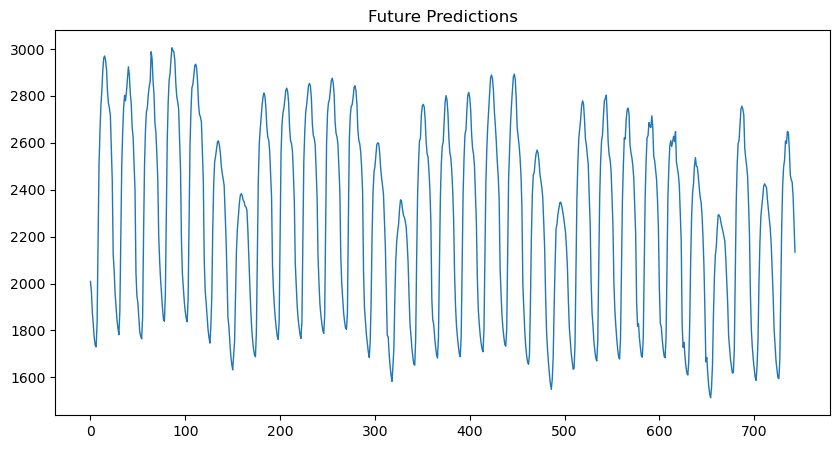

In [499]:
if(~config.draw):
    submission[config.target].plot(figsize=(10, 5),
                                   ms=1,
                                   lw=1,
                                   title='Future Predictions')
    plt.show()

In [500]:
if(config.draw):
    f, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(X_train_prophet.index, X_train_prophet["y"], color='r')
    fig = reg4.plot(y_pred4_frcst, ax=ax)

In [501]:
if(config.sub):
    config.submission_20 = submission[:20]
    config.mean = submission[config.target].mean()

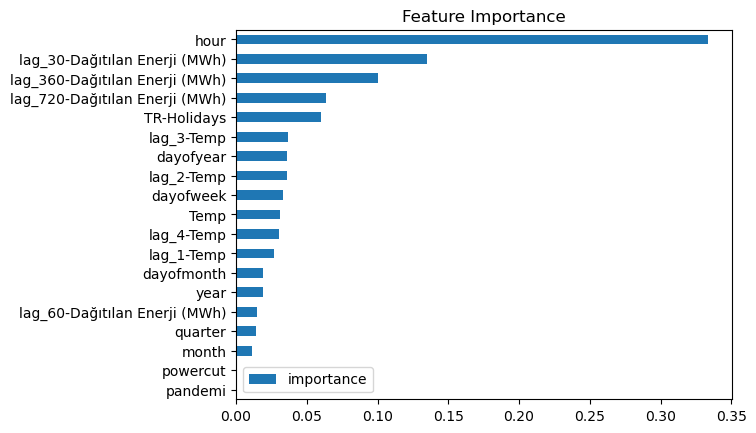

In [504]:
if("XGB" in config.ensamble_list):
    fi = pd.DataFrame(data=reg1.feature_importances_,
                 index=reg1.feature_names_in_,
                 columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show()

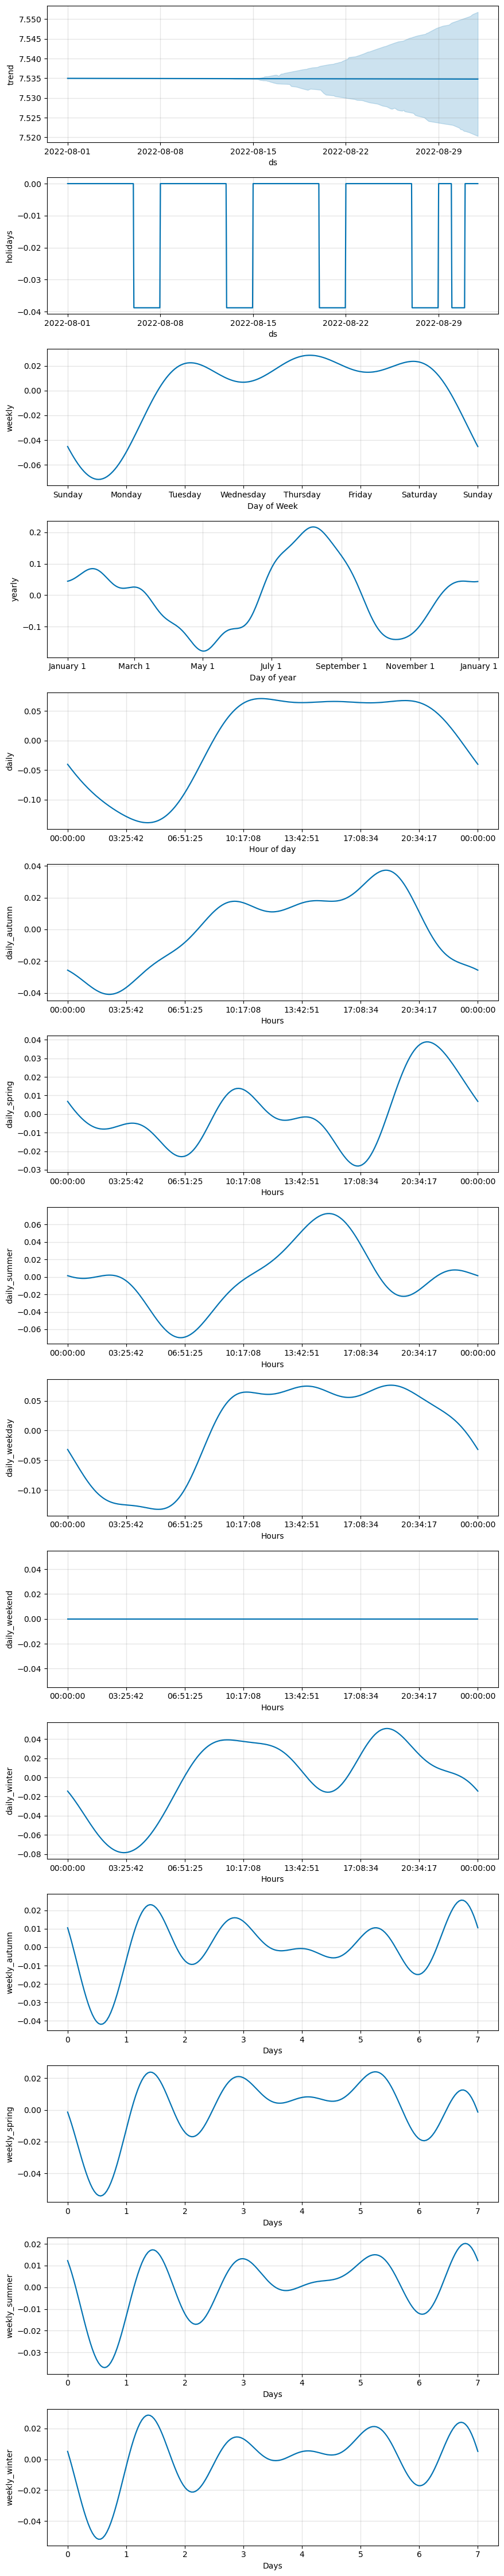

In [505]:
if("Prophet" in config.ensamble_list):    
    fig = reg4.plot_components(y_pred4_frcst)
    plt.show()

In [506]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.scatter(X_test_prophet.ds, y_pred, color='r')
# fig = reg4.plot(y_pred4_frcst, ax=ax)
# ax.set_xbound(lower=X_test_prophet.ds.min(),
#               upper=X_test_prophet.ds.max())
# ax.set_ylim(6.5, 8)
# plot = plt.suptitle(f"\n {X_test_prophet.ds.min()} to {X_test_prophet.ds.max()}")

In [507]:
config.debug_log()

--------------------------------------------------
Began Time: 2023-04-22 20:22:05.249902
----------------------------------------
Model_List: ['RF', 'XGB', 'LGBM', 'Prophet'] Weights: [0.35, 0.15, 0.15, 0.35]
----------------------------------------
Features:
['Temp', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'TR-Holidays', 'pandemi', 'powercut']['lag_30-Dağıtılan Enerji (MWh)', 'lag_60-Dağıtılan Enerji (MWh)', 'lag_360-Dağıtılan Enerji (MWh)', 'lag_720-Dağıtılan Enerji (MWh)', 'lag_1-Temp', 'lag_2-Temp', 'lag_3-Temp', 'lag_4-Temp'][]['is_spring', 'is_summer', 'is_autumn', 'is_winter', 'is_weekend', 'is_weekday']
Target:
Dağıtılan Enerji (MWh)
----------------------------------------
Temp: True 
 Outilar: False 
 Rolling: False
Holiday: True ,Drop_med: True
Time_feature: True
Lag: True
----------------------------------------
Metric: MAPE
Score across folds 0.1006
Fold scores:[0.11789471008620195, 0.09090678560413701, 0.09302994839184929]
Predictes va

In [508]:
if(config.sub):
    submission.to_csv(f"submission-{config.end}.csv",index=False)
